# Sentiment Analysis on StockTwits

In [13]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

from helper import plot_history

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


data_dir = '../nlp_datasets/12_twitter_sentiment/'

In [2]:
def load_data():
    with open(data_dir+'train_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [4]:
# cut the data short to make learning faster keep only 8010 of them
#random_indices = np.random.choice(range(df.shape[0]), size=8010)
#df = df.loc[random_indices]
df_top = data.loc[:50000]

In [5]:
df= df_top.copy()
df.sentiment.unique()

array([ 2,  1,  0, -2, -1])

In [6]:
# convert the labels to [0-4] instead of [-2, 2]
df['sentiment'] = df['sentiment'].apply(lambda x:x+2)

In [7]:
print ( "unique sentiments:",df.sentiment.unique() )
print (f"data shape:{df.shape}")
df.head(5)

unique sentiments: [4 3 2 0 1]
data shape:(50001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z


In [8]:
print (f" new data shape:{df.shape}")
df.head(2)

 new data shape:(50001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z


## Class (Im)balance

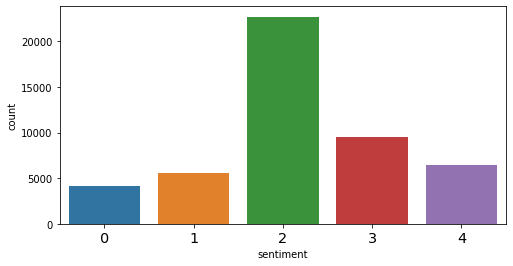

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,4));
sns.countplot(df['sentiment'], ax=ax);
plt.xticks(fontsize='x-large');

In [16]:
def find_counts(df):
    df_counts =df.groupby("sentiment", axis=0).count()
    df_counts["ratio (pct)"] = 100*df_counts["message_body"]/sum(df_counts["message_body"])
    return df_counts

find_counts(df)

,message_body,message_processed,ratio (pct)
sentiment,,,
0,4145,4145,8.579649
1,5526,5526,11.438152
2,22683,22683,46.951068
3,9508,9508,19.680411
4,6450,6450,13.350720


In [17]:
def balance_class(df, col='sentiment'):
    dfb=df.copy()
    counts = dict(dfb[col].value_counts())
    print ("initial counts for each classes:", counts)
    min_count = min(counts.values())
    min_indx  = [k for k in counts.keys() if counts[k]==min_count][0]
    print ("min_index:", min_indx, "min count:", min_count)

    for s in dfb[col].unique():
        delete_after = dfb[dfb[col]==min_indx].shape[0] 
        indices_to_delete = dfb[dfb[col]==s].index.values[delete_after:]
        dfb = dfb.drop(index=indices_to_delete, axis=0)
    return dfb

df=balance_class(df, col='sentiment')
find_counts(df)


initial counts for each classes: {2: 22683, 3: 9508, 4: 6450, 1: 5526, 0: 4145}
min_index: 0 min count: 4145


,message_body,message_processed,ratio (pct)
sentiment,,,
0,4145,4145,20.0
1,4145,4145,20.0
2,4145,4145,20.0
3,4145,4145,20.0
4,4145,4145,20.0


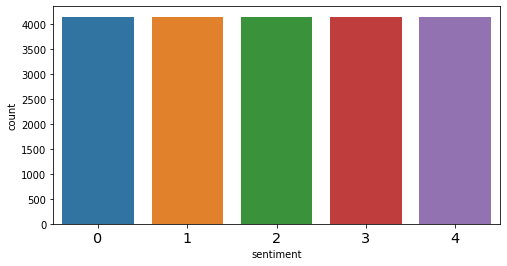

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,4));
sns.countplot(df['sentiment'], ax=ax);
plt.xticks(fontsize='x-large');

In [19]:
def print_twts():
    for i in df.sentiment.unique():
        print ("Tweets with sentiment: ", i)
        twt=df[df['sentiment']==i].sample(3)['message_body'].values
        for i in range(3):
            print (twt[i])
            print ()
        print ("===================")
        print ()
        
print_twts()

Tweets with sentiment:  4
$XLNX&#39;s Gross Margins is a key growth metric for their next report on 07/25 AMC. Will they beat last quarter&#39;s 70.67% Gross Margins?
http://www.estimize.com/intro/xlnx?chart=historical&amp;metric_name=gross_margins&amp;utm_content=XLNX&amp;utm_medium=key_metric&amp;utm_source=stocktwits

$GE Ridiculously oversold, absurdly undervalued!

$T holding $33 calls at .12 average, might average up tomorrow. Still cheap.


Tweets with sentiment:  3
$CHK - We need a $6.00 to day.

$X A  potent dose of &#39;truth serum&#39; and waterboarding should make them sing like a bird. You can run, but you can&#39;t hide.

$NVDA can we sustain? if this holds ill go in, if not, ill stay waiting


Tweets with sentiment:  2
$WYNN is this the end?

$T Download movies in 5G in 2-4 seconds.

$LOW reported 0.6% Same Store Sales last quarter. Next report is on 08/22 BMO. Jury is still out on expectations. What’s yours?
http://www.estimize.com/intro/low?chart=historical&amp;metric_

In [20]:
STOPWORDS = set(stopwords.words('english'))

st =  PorterStemmer()

def process_twt(twt):
    twt = twt.lower()                   # Lowercase the twit message
    twt = re.sub(r'https?://\S+', ' ', twt)# Replace URLs with a space
    twt = re.sub(r'\$\S+', ' ', twt)       # Replace ticker symbols with a space
    twt = re.sub(r'\@\S+', ' ', twt)       # Replace StockTwits usernames with a space.
    twt = re.sub(r'[^a-zA-Z]', ' ', twt)   # Replace everything not a letter with a space    
    #remove stopwords and stemmize
    twt=" ".join(st.stem(w) for w in twt.split() if w not in STOPWORDS)
    return twt


txt=df.message_body.values[1112]
print ("original  twt: \t", txt)
print ("processed twt:\t", process_twt(txt) )


original  twt: 	 $CXO I like how it settled back into channel. I will be watching this one this week for sure for a potential swing set up 🌊🏄🏾‍♂️
processed twt:	 like settl back channel watch one week sure potenti swing set


In [21]:
df['message_processed'] = df["message_body"].apply(process_twt)
# remove columns with empty message after processing
df = df[df['message_processed']!='']
# drop unneccessary columns
df = df[['sentiment', 'message_body', 'message_processed']]
df.head(4)

,sentiment,message_body,message_processed
0,4,$FITB great buy at 26.00...ill wait,great buy ill wait
2,4,#STAAnalystAlert for $TDG : Jefferies Maintain...,staanalystalert jefferi maintain rate hold set...
3,3,$AMD I heard there’s a guy who knows someone w...,heard guy know someon think somebodi know some...
4,2,$AMD reveal yourself!,reveal


## Prepare input for Model
- train, test, val split
- tokenize the text
- Pad the Sequences to a certain length
- convert the y labels to categorical

In [22]:
def split_data(data):
    X_train_, X_test, y_train_, y_test = train_test_split(data['message_processed'].values, data['sentiment'].values, test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [23]:
MAX_SEQ_LEN = 2000 # length of each text
MAX_WORDS   = 1000 # use only this many max used words

def prepare_data_for_model(X_train, X_val, X_test,
                               y_train, y_val, y_test, 
                               text_to_matrix=False):
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)

    if text_to_matrix:
        X_train = tokenizer.texts_to_matrix(X_train)
        X_val   = tokenizer.texts_to_matrix(X_val)    
        X_test  = tokenizer.texts_to_matrix(X_test)
    else:
        X_train = tokenizer.texts_to_sequences(X_train)
        X_val   = tokenizer.texts_to_sequences(X_val)    
        X_test  = tokenizer.texts_to_sequences(X_test)

        X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    
    y_train = to_categorical(y_train)
    y_val   = to_categorical(y_val)
    y_test  = to_categorical(y_test)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.layers import MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

## Model: Dense

In [45]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=True)

X_train.shape: (12435, 1000) y_train.shape:(12435, 5)
X_test.shape: (4145, 1000) y_test.shape:(4145, 5)
X_val.shape: (4145, 1000) y_val.shape:(4145, 5)


In [46]:
def make_model(X, y):
    # Build the model
    model = Sequential()
    model.add(Dense(16, input_shape=(MAX_WORDS,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model1 = make_model(X_train, y_train)
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                16016     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [47]:
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_val, y_val), 
                      batch_size=32,
                      epochs=5,
                      verbose=1)

Epoch 1/5
389/389 [==============================] - 1s 1ms/step - loss: 1.4584 - accuracy: 0.4234 - val_loss: 1.2449 - val_accuracy: 0.5614
Epoch 2/5
389/389 [==============================] - 0s 1ms/step - loss: 1.1374 - accuracy: 0.5787 - val_loss: 1.0561 - val_accuracy: 0.6092
Epoch 3/5
389/389 [==============================] - 0s 1ms/step - loss: 1.0020 - accuracy: 0.6253 - val_loss: 1.0093 - val_accuracy: 0.6159
Epoch 4/5
389/389 [==============================] - 0s 1ms/step - loss: 0.9321 - accuracy: 0.6487 - val_loss: 0.9911 - val_accuracy: 0.6203
Epoch 5/5
389/389 [==============================] - 0s 1ms/step - loss: 0.8889 - accuracy: 0.6638 - val_loss: 0.9853 - val_accuracy: 0.6244


130/130 [==============================] - 0s 1ms/step - loss: 0.9545 - accuracy: 0.6273
Test accuracy: 62.73%


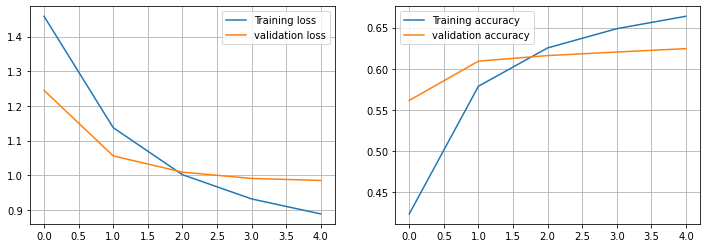

In [49]:
from helper import plot_history

score = model1.evaluate(X_test, y_test, batch_size=32)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history1)

## Model: LSTM+Dense

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=False)

X_train.shape: (12435, 2000) y_train.shape:(12435, 5)
X_test.shape: (4145, 2000) y_test.shape:(4145, 5)
X_val.shape: (4145, 2000) y_val.shape:(4145, 5)


In [42]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model(X_train, y_train)
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 16)          16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 85        
Total params: 18,197
Trainable params: 18,197
Non-trainable params: 0
_________________________________________________________________


In [44]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=5,
                    batch_size=32,
                    verbose=1)

In [ ]:
from helper import plot_history

score = model2.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history2)

I was able to reach an accuracy of around 50% with this but it took roughly 5 minutes for 
single epoch. So didn't run.

## Model: Bidirectional LSTM

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=False)

In [ ]:
def make_model_bidirectional(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Conv1D(32, kernel_size = 3, padding = "valid"))
    model.add(GlobalMaxPool1D())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model3 = make_model_bidirectional(X_train, y_train)
model3.summary()

In [ ]:
history3 = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=10,
                    batch_size=16,
                    verbose=1)

In [ ]:
from helper import plot_history

score = model3.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history3)

## Evaluation on test set

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
ypred = model1.predict(X_test)

In [52]:
np.argmax(y_test,axis=1)

array([3, 3, 4, ..., 4, 3, 4])

[[560 119  71  54  34]
 [ 80 497  96  93  71]
 [ 28  77 589 112  38]
 [ 60  93 127 403 133]
 [ 31  29  52 147 551]]


<AxesSubplot:>

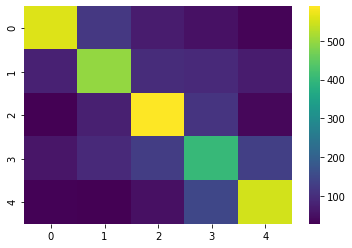

In [55]:
confusionmatrix=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(ypred,axis=1))
print ( confusionmatrix )
sns.heatmap(confusionmatrix, cmap='viridis')


## Save the Model, tokenizer and configs

In [56]:
import pickle
import json

model2.save('model_dense')
with open('tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_dense/assets


## Load the saved Model, tokenizer and configs

In [58]:
# loading the saved model, vocab, filtered_words
from tensorflow.keras.models import load_model
model = load_model('./model_dense')

with open('tokenizer.pkl', 'rb') as fp:
    tokenizer=pickle.load(fp) 
print ("Model Loaded.")

Model Loaded.


## Predictions

In [59]:
def Prediction(txt_orig, model=model, tokenizer=tokenizer, MAX_SEQ_LEN=MAX_SEQ_LEN):
    sent_dict={0:'very_bad', 1:'bad', 2:'neutral', 3:'good', 4:'very_good'}
    txt = process_twt(txt_orig)
    X_in = tokenizer.texts_to_sequences([txt])
    X_in = pad_sequences(X_in, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    y_out = model.predict(X_in)
    sent = np.argmax(y_out,axis=1)[0]

    print (f"The following text\n\n {txt_orig} \n\n\
    has a sentiment \n {sent} ({sent_dict[sent]})\n\n on the following scale\n\n\
    {sent_dict}")

text = " $AAPL had a big increase. I am really happy for this."
Prediction(text)

The following text

  $AAPL had a big increase. I am really happy for this. 

    has a sentiment 
 4 (very_good)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}
